# Global Sea Surface Temperature Trends

**Objective: Calculate Global Rates of Change, Highlight Regions of Specific Percentiles.**

## Product 3: Global Change Rate Netcdfs, Percentile Rankings

Steps for calculating change rates across netcdf files can be found here: http://atedstone.github.io/rate-of-change-maps/. The desired end result is a map with the global OISST extent that displays the sea surface temperature warming rate of each cell. Depending on how difficult/time-consuming that is to generate a second variable ranking the warming rates will also be added. In this way areas can be highlighted by how rapidly they are warming relative to other areas on the planet.

Regional differences in sea surface temperature change-rates are important for management considerations surrounding ecosystem resiliency around climate change. An important step in this process is mapping out what the change rates are globally.


In [1]:
import xarray as xr
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os
import oisstools as ot
import warnings

#### 1. Set workspace
workspace = "local"
box_root = ot.set_workspace("local")
_cache_root = ot.set_cache_root(box_root)

# Set start and End year for warming trends
trend_start_year = 1982
trend_end_year = 2023
print(f"Processing Warming Rates for {trend_start_year} to {trend_end_year}.")

# Do we want sea surface temperature, or climate anomalies?
observation_type = "observed"
print(f"Warming Rates Calculated Using {observation_type} SST")

Processing Warming Rates for 1982 to 2023.
Warming Rates Calculated Using observed SST


## Loading the OISST Files:

First step is to get everything loaded, so step one is to load in all the yearly oisst data files. The files all have the same naming convention so we just need to iterate through the available years to generate a list of all the files.

**NOTE:** Most recent year may need to be excluded as it is not a complete year. An alternative could be to weight the years by their number of days.

In [2]:
# Open the OISSt Files
oisst = ot.load_box_oisst(
    box_root, 
    trend_start_year, 
    trend_end_year, 
    anomalies = False, 
    do_parallel = True)
oisst = oisst.chunk({"lat" : 50, "lon" : 50})
oisst

,Array,Chunk
Bytes,59.25 GiB,3.49 MiB
Shape,"(15340, 720, 1440)","(366, 50, 50)"
Count,36666 Tasks,18270 Chunks
Type,float32,numpy.ndarray


# Get Annual Averages

Having an annual rate of change rather than a daily rate of change does two things for us. Its a more tangible rate for comparison, and it makes computation take a great deal less time.

In [3]:
# Get yearly averages
with warnings.catch_warnings():
    year_avg = oisst.groupby('time.year').mean()

# Save Yearly Averages? - Or do it Together with Anomalies...

/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
 

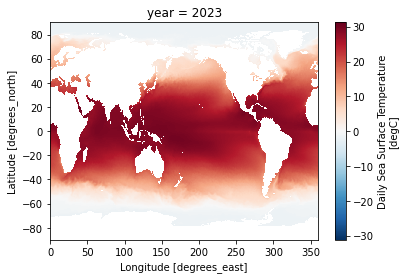

In [4]:
# Plot the yearly average for one year
year_avg['sst'].sel(year = 2023).plot()

## Calculating Trends

The default here is to use all the data available, so the fall of 1981-2020. This is going to be changed to a function that takes input start/end dates. The following function takes an array with year as the time dimension and returns the annual trend in sst.

In [5]:
def calc_warming_trends(year_avg, start_yr, end_yr):
    
    # Filtering the Years
    print(f"Calculating warming trends from {start_yr} to {end_yr}.")
    year_subset = year_avg.sel(year = slice(start_yr, end_yr))
    
    # Pull arrays of the sea surface temperatures and the time dimensions
    vals  = year_subset.sst.values
    years = year_subset.year.values

    # Reshape to an array with as many rows as years and as many columns as there are pixels
    vals2 = vals.reshape(len(years), -1)

    # Do a first-degree polyfit (i.e. a line)
    regressions = np.polyfit(years, vals2, 1)

    # Get the coefficients back
    trends = regressions[0, :].reshape(vals.shape[1], vals.shape[2])
    
    # Return the trends table
    return trends
    

## Calculate Global Annual Warming Rates

Using the above function and the input years laid out in the first code chunk we can get the warming rates we want.

In [6]:
# Run function to get trends, start and end year determined at top
trends = ot.calc_warming_trends(
    year_avg = year_avg, 
    start_yr = trend_start_year, 
    end_yr = trend_end_year)

# convert to xarray dataArray, rename dimensions, get coordinates from original
trend_xr = xr.DataArray(trends).rename({"dim_0" : "lat", "dim_1" : "lon"}).assign_coords(lon = oisst.coords["lon"], lat = oisst.coords["lat"])
trend_xr

Calculating warming trends from 1982 to 2023.


<xarray.DataArray (lat: 720, lon: 1440)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.00310662, -0.00336152, -0.00348783, ..., -0.00361926,
        -0.00348065, -0.00318199],
       [-0.00328517, -0.00378713, -0.00402655, ..., -0.00409178,
        -0.00389915, -0.00335391],
       [-0.00443415, -0.00443281, -0.00440052, ..., -0.00439898,
        -0.00443418, -0.0044343 ]])
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88

### Convert trend table to array

Re-format the numpy array to an xarray dataarray, do some plotting for verification.

Text(0.5, 1.0, 'Annual Warming Rate - Degrees C')

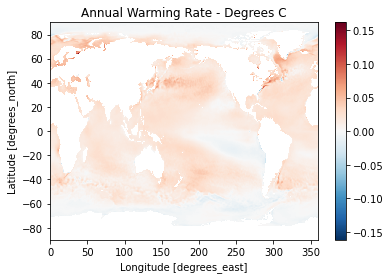

In [7]:
# Plot to see
trend_xr.plot()
plt.title("Annual Warming Rate - Degrees C")

# Next Steps: Rankings and Quartiles

 - Get the percentiles of these warming rate values
 - Put these warming rates & their percentiles into a DataArrayDataset 
 - Pull lat/lon dimensions from original, apply attributes and metadata that details start/end date
 - Export Somewhere
 
`trends` is still a numpy array so first step is to get the percentiles of those values
`np.percentile` can be used to return distinct quantile breaks from the data:

I think what would be better is to rank them and divide by the number of ranks for a continuous scale 0-1

In [8]:
# source: https://stackoverflow.com/questions/5284646/rank-items-in-an-array-using-python-numpy-without-sorting-array-twice

#### 1. Copy the trend values so we can change them without impacting originals
trends_rank = trends.copy()


#### 2. Get the values and their matching indices

# The commented out code is not necessary

# # Weird idea, but as a way to flag NAS we can set them to an obnoxiously low value, then using the total number of NA's 
# # Just count the true rank as beginning after the known NAs
# total_nas = len(trends_rank[np.isnan(trends_rank)])
# total_nas

# # or replace nan values
# min_rate = trends_nona.min()
# trends_rank[np.isnan(trends_rank)] = min_rate - .05
# xr.DataArray(trends_rank).plot()


#### 3. drop the NA values
# pull array of just non-nan values
trends_nona = trends_rank[~np.isnan(trends_rank)]


# order + rank them
order = trends_nona.argsort()
rank  = order.argsort()

#scale by max rank to get percentiles
max_rank = rank.max()
rank_norm = rank / max_rank
rank_norm

# Replace the non-NA values in trends_rank with the scaled ranks

# Order 
order_out = trends_rank.copy()
order_out[~np.isnan(order_out)] = order

# Their Rank as Percentile
rank_out = trends_rank.copy()
rank_out[~np.isnan(rank_out)] = rank_norm



## Re-format to xarray Datasets

Before combining everything just reformat to the final form and do some plotting to make sure everything makes sense.

In [9]:
# We now have 2 more arrays, one with the order, the other with their ranks
order_xr = xr.DataArray(order_out).rename({"dim_0" : "lat", "dim_1" : "lon"}).assign_coords(lon = oisst.coords["lon"], lat = oisst.coords["lat"])
rank_xr  = xr.DataArray(rank_out).rename({"dim_0" : "lat", "dim_1" : "lon"}).assign_coords(lon = oisst.coords["lon"], lat = oisst.coords["lat"])


## Map everything for visual check

My understanding of python is a little shaky so at a bare minimum the warming rate map should have same visual patterns as their rankings.

Text(0.5, 1.0, 'Annual Warming Rates - By Pixel')

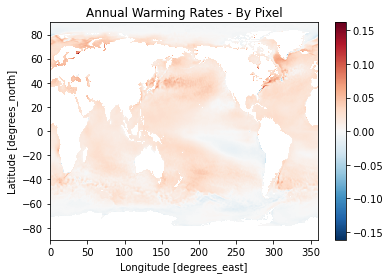

In [10]:
trend_xr.plot()
plt.title("Annual Warming Rates - By Pixel")

Text(0.5, 1.0, 'Warming Rate Rankings')

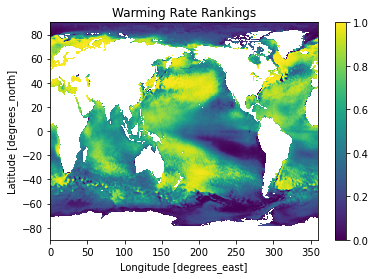

In [11]:
# Plot warming rate percentile ranks
rank_xr.plot() 
plt.title("Warming Rate Rankings")

## Adding Trends and Ranks back into xr.Dataset

We now have arrays of matching dimensions to the orginal oisst data indicating their warming rates as well as their rankings. We want to now assemble them into a single xarray dataset with the proper lat/lon dimensions and attributes relaying important metadata.

In [12]:
# Make it an xarray Dataset
trends_ds = trend_xr.to_dataset(name = "annual_warming_rate")

# Assign the warming rate percentiles as another variable
trends_ds = trends_ds.assign(rate_percentile = rank_xr)

# print to check
trends_ds

<xarray.Dataset>
Dimensions:              (lon: 1440, lat: 720)
Coordinates:
  * lon                  (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat                  (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
Data variables:
    annual_warming_rate  (lat, lon) float64 nan nan nan ... -0.004434 -0.004434
    rate_percentile      (lat, lon) float64 nan nan nan ... 0.07086 0.07085

## Pulling top 20%

Text(0.5, 1.0, 'Warming Rates in top 80.0% - By Pixel')

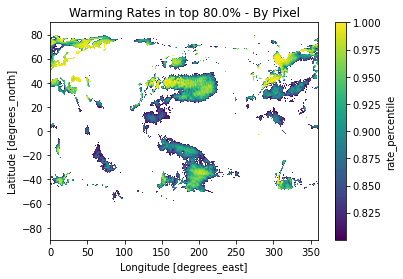

In [13]:
# Plot top X %
x_percentile = .80
trends_ds.where(trends_ds.rate_percentile > x_percentile).rate_percentile.plot()
plt.title(f"Warming Rates in top {x_percentile * 100}% - By Pixel")

# Adding Metadata

May need to do it both for the rates and for the ranks, but lets just see...

In [14]:
#Change the Attributes for the dataset
import datetime as dt 
today = str(dt.date.today())

trends_ds.attrs['title']         = 'Annual sea surface temperature warming rates from NOAA OISSTv2 SST Data'
trends_ds.attrs['institution']   = 'Gulf of Maine Research Institute'
trends_ds.attrs['source']        = 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/'
trends_ds.attrs['comment']       = 'Sea surface temperature averaged by year prior to use in linear regression for warming rates. Warming rates processed at level of individual pixels. Warming rate percentile is the ranking of low-high warming rate of an individual cell divided by total number of cells ranked to range 0-1.'
trends_ds.attrs['history']       = f'Warming rates calculated {today}'
trends_ds.attrs['references']    = 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html'
trends_ds.attrs['dataset_title'] = 'GMRI Sea Surface Warming Rates and Rankings - OISST'
trends_ds.attrs['reference_period'] = f'Rates and ranks calculated using years {trend_start_year} to {trend_end_year}'
trends_ds.attrs

{'title': 'Annual sea surface temperature warming rates from NOAA OISSTv2 SST Data',
 'institution': 'Gulf of Maine Research Institute',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Sea surface temperature averaged by year prior to use in linear regression for warming rates. Warming rates processed at level of individual pixels. Warming rate percentile is the ranking of low-high warming rate of an individual cell divided by total number of cells ranked to range 0-1.',
 'history': 'Warming rates calculated 2024-01-30',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'GMRI Sea Surface Warming Rates and Rankings - OISST',
 'reference_period': 'Rates and ranks calculated using years 1982 to 2023'}

In [15]:
# And again for the warming rate data?
trends_ds.annual_warming_rate.attrs['long_name']   = "Annual Sea Surface Temperature Warming Rate"
trends_ds.annual_warming_rate.attrs['units']       = "degC"
trends_ds.annual_warming_rate.attrs['valid_range'] = "array([-2., 2.], dtype=float32)"
trends_ds.annual_warming_rate.attrs['dataset']     = "NOAA High-resolution Blended Analysis"
trends_ds.annual_warming_rate.attrs['var_desc']    = "Sea Surface Temperature"
trends_ds.annual_warming_rate.attrs['level_desc']  = "Surface"
trends_ds.annual_warming_rate.attrs['statistic']   = "Mean"
trends_ds.annual_warming_rate.attrs['parent_stat'] = "Mean Annual Sea Surface Temperature"
trends_ds.annual_warming_rate.attrs

{'long_name': 'Annual Sea Surface Temperature Warming Rate',
 'units': 'degC',
 'valid_range': 'array([-2., 2.], dtype=float32)',
 'dataset': 'NOAA High-resolution Blended Analysis',
 'var_desc': 'Sea Surface Temperature',
 'level_desc': 'Surface',
 'statistic': 'Mean',
 'parent_stat': 'Mean Annual Sea Surface Temperature'}

In [16]:
# And again for the warming rate ranks?
trends_ds.rate_percentile.attrs['long_name']   = "Annual Sea Surface Temperature Warming Rate Rank"
trends_ds.rate_percentile.attrs['units']       = "Percentile"
trends_ds.rate_percentile.attrs['valid_range'] = "array([0., 1.], dtype=float32)"
trends_ds.rate_percentile.attrs['dataset']     = "NOAA High-resolution Blended Analysis"
trends_ds.rate_percentile.attrs['var_desc']    = "Sea Surface Temperature"
trends_ds.rate_percentile.attrs['level_desc']  = "Surface"
trends_ds.rate_percentile.attrs['statistic']   = "Rank Percentile"
trends_ds.rate_percentile.attrs['parent_stat'] = "Annual Sea Surface Temperature Warming Rates"
trends_ds.rate_percentile.attrs

{'long_name': 'Annual Sea Surface Temperature Warming Rate Rank',
 'units': 'Percentile',
 'valid_range': 'array([0., 1.], dtype=float32)',
 'dataset': 'NOAA High-resolution Blended Analysis',
 'var_desc': 'Sea Surface Temperature',
 'level_desc': 'Surface',
 'statistic': 'Rank Percentile',
 'parent_stat': 'Annual Sea Surface Temperature Warming Rates'}

# Exporting the Netcdf

In [17]:
#trends_ds.to_netcdf('NSF OKN Demo Data/oisst/warming_rates/annual_warming_rates.nc')
export_file = f"{box_root}RES_Data/OISST/oisst_mainstays/warming_rates/annual_warming_rates{trend_start_year}to{trend_end_year}.nc"
trends_ds.to_netcdf(export_file)
print(f"Warming rates of {observation_type} sst saved for reference period: {trend_start_year} to {trend_end_year}")
print("Exported to: " + export_file)

Warming rates of observed sst saved for reference period: 1982 to 2023
Exported to: /Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/OISST/oisst_mainstays/warming_rates/annual_warming_rates1982to2023.nc
